# Making dataset using pretrained generator

In [1]:
import tensorflow as tf

STYLE_FILES = './input/laplus/long'


windowSize = 72         # the input width of the model
vecLen = 128            # length of vector generated by siamese vector
shape = 24              # length of time axis of split specrograms to feed to generator            

batch_size = 16         #batch size



## Reading

In [2]:

from MelGAN.processing import sampleRate
from utils import loadFile
from glob import glob
import numpy as np

def loadData(path):
    files = glob(f'{path}/*.wav')
    data = []
    for file in files:
        x = loadFile(file, sampleRate)
        data.append(x)
    print(f'loaded {len(files)} files from {path}')
    return data


x_style = loadData(STYLE_FILES)


print(f'sampleRate: {sampleRate}')



loaded 1 files from ./input/laplus/long
sampleRate: 16000


## Load Pretrained Generator

In [3]:

from MelGAN.processing import hop
from MelGAN.models import *
import tensorflow as tf

PRETRAINED_MODEL = './saved_model\clptolapus_4\epoch_2'

model_G = build_generator((hop, shape, 1))
model_G.load_weights(os.path.join(PRETRAINED_MODEL, 'gen.h5'))

print(f'load model from {PRETRAINED_MODEL}')


load model from ./saved_model\clptolapus_4\epoch_2


## Making Dataset for WaveGLOW

In [3]:

from MelGAN.processing import wav2spectrum, spectrum2wav
from torch.utils.data import Dataset, DataLoader
import WaveGlow.processing
import torch 

crop_length = 4416

print(f'use {crop_length} as crop length.')

class myDataset(Dataset):
    def __init__(self, wave, sampleNumber = 1000):

        self.spec = []
        self.wave = []

        for x in wave:
            
            W = len(x)
            
            # crop random samples
            indices = np.random.randint(W - crop_length, size = sampleNumber)

            for i in indices:

                wx = x[i: i + crop_length]

                sx = wav2spectrum(wx)[None, :, :, None]

                sy = model_G(sx)

                sy = np.array(sy)
                wy = spectrum2wav(np.array(sy).squeeze(), maxiter = 100)        
                
                S = WaveGlow.processing.wav2spectrum(wy)

                # S = s[:, i: i + crop_length // hop_length]
                # S = model_G(S[None, :, :, :], training = False)
                # S = np.array(S).squeeze()

                # sp = torch.tensor(S, requires_grad = False)
                # wv = torch.tensor(x[j: j + crop_length], requires_grad = False)

                self.spec.append(S)
                self.wave.append(torch.tensor(wy))             

    def __getitem__(self, index):
        return self.spec[index], self.wave[index]

    def __len__(self):
        return len(self.spec) 





use 4416 as crop length.


In [ ]:
dataset = myDataset(x_style)

In [12]:
# Save my dataset
import pickle as pkl

with open(os.path.join('./dataset/clp2laplus', 'WaveDataset_2.pkl'), 'wb') as f:
    pkl.dump(dataset, f)


# Load Dataset and using transfer learning to enhence the quality with WaveGlow 

In [4]:
from torch.utils.data import DataLoader
import pickle as pkl

with open(os.path.join('./dataset/clp2laplus', 'WaveDataset_2.pkl'), 'rb') as f:
    dataset = pkl.load(f)

train_loader = DataLoader(
    dataset, batch_size = 4
)


## Load the pretrained model

In [5]:

from IPython.display import clear_output
import torch

PRETRAINED_MODEL = './WaveGlow/waveglow_256channels_universal_v5.pt'
wave = torch.load(PRETRAINED_MODEL)['model']
wave = wave.remove_weightnorm(wave)
clear_output()



## transfer learning 

In [6]:

from glow import WaveGlowLoss
import torch

saved_experiment_path = './saved_model/waveglow_QQ'

if not os.path.exists(saved_experiment_path):
    os.mkdir(saved_experiment_path)


learning_rate_waveglow = 0.0001

max_epochs_waveglow = 2

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loss_metric =  WaveGlowLoss(sigma = 1.0)


pretrained_wave_model = './saved_model/waveglow_exp_4'
pretrained_wave = False

if pretrained_wave:
    wave.load_state_dict(torch.load(os.path.join(pretrained_wave_model, 'wave.pt')))


In [7]:


import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam( 
    wave.parameters(),
    lr = learning_rate_waveglow
)


wave.to(device)

wave.train()


for epoch in range(1, max_epochs_waveglow + 1):

    with tqdm(train_loader, unit = 'batch') as tepoch:

        for s, x in tepoch:

            tepoch.set_description(f'Training Epoch {epoch:03d}/{max_epochs_waveglow:03d}')

            optimizer.zero_grad()

            
            x = x.to(device)
            s = s.to(device)
        

            loss = loss_metric(wave((s, x)))
                
            loss.backward()

            optimizer.step()

            tepoch.set_postfix({'loss': loss.item()})


torch.save(wave.state_dict(), os.path.join(saved_experiment_path, 'wave.pt'))



Training Epoch 002/002: 100%|██████████| 250/250 [01:53<00:00,  2.20batch/s, loss=-4.9] 


# Test the model

In [1]:

load_gen_model_path = './saved_model/clptolapus_4/epoch_2'         # path of the pretrained model
load_wav_model_path = './saved_model/waveglow_QQ'   # path of the saved model
test_waveform_file = './input/clp/short/clp_test.wav'   # path of the test waveform

shape = 24


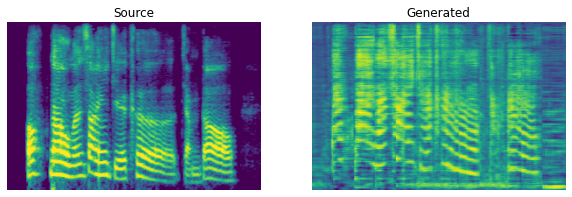

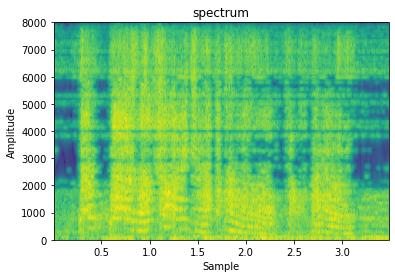

In [2]:


from utils import loadFile, writeFile, plot_spectrum, plot_spectrogram_with_raw_signal
from MelGAN.processing import hop, sampleRate, spectrum2wav
from WaveGlow.processing import wav2spectrum, Denoiser
from IPython.display import clear_output
# from WaveGlow.vars import model_config
# from WaveGlow.vars import sample_rate
from MelGAN.models import *
from glow import WaveGlow
import MelGAN.processing
from numba import cuda
import numpy as np
import torch

# load generator
model_G = build_generator((hop, shape, 1))
model_G.load_weights(os.path.join(load_gen_model_path, 'gen.h5'))

# load wave file

x_test = loadFile(test_waveform_file, sampleRate)

s_test = MelGAN.processing.wav2spectrum(x_test)
print(s_test.shape)

# generate spectrum
H, W = s_test.shape
s_output = np.zeros((H, W))

for i in range(0, W - shape, shape):
    s_output[:, i: i + shape] = np.array(model_G(s_test[:, i: i + shape].reshape(1, hop, shape, 1), training = False)).squeeze()

s_output[:, -shape:] = np.array(model_G(s_test[: , -shape:].reshape(1, hop, shape, 1), training = False)).squeeze()

x_output = spectrum2wav(s_output)

print(x_output)
# clear memory used for tensorflow 
device = cuda.get_current_device()
device.reset()


PRETRAINED_MODEL = './WaveGlow/waveglow_256channels_universal_v5.pt'
wave = torch.load(PRETRAINED_MODEL)['model']
wave = wave.remove_weightnorm(wave)


wave.load_state_dict(torch.load(os.path.join(load_wav_model_path, 'wave.pt')))
clear_output()

plot_spectrum(s_test, s_output)

S = wav2spectrum(x_output)

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


wave.eval()
wave.to(device)

model = Denoiser(wave) #, filter_length = 6 * hop, n_overlap = 6, win_length = 6 * hop, mode = 'special')
model.to(device)

# transforming to waveform
mel = torch.FloatTensor(S[None, :, :]).to(device)

with torch.no_grad(): 
    audio = wave.infer(mel, sigma = 1.0)
    audio = model(audio)

audio = audio.squeeze()
audio = audio.cpu().numpy()

plot_spectrogram_with_raw_signal(audio, sampleRate)

writeFile('./output/waveglow_BQ.wav', x_output, sampleRate)
writeFile('./output/waveglow_QQ.wav', audio, sampleRate)

